In [1]:
import numpy as np
import odl

In [2]:
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[300, 300], dtype='float32')

# Make a parallel beam geometry with flat detector
# Angles: uniformly spaced, n = 360, min = 0, max = pi
angle_partition = odl.uniform_partition(0, np.pi, 360)
# Detector: uniformly sampled, n = 512, min = -30, max = 30
detector_partition = odl.uniform_partition(-30, 30, 512)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)

# Create the forward operator
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

/home/w/wuebbel/.local/lib/python3.10/site-packages/odl/tomo/backends/skimage_radon.py:244: RuntimeWarning: The 'skimage' backend may be too slow for volumes of this size. Consider using 'astra_cpu', or 'astra_cuda' if your machine has an Nvidia GPU.
  warnings.warn(
/home/w/wuebbel/.local/lib/python3.10/site-packages/odl/discr/discr_utils.py:628: UserWarning: Unable to infer accurate dtype for interpolation coefficients, defaulting to `float`.
  warn("Unable to infer accurate dtype for"


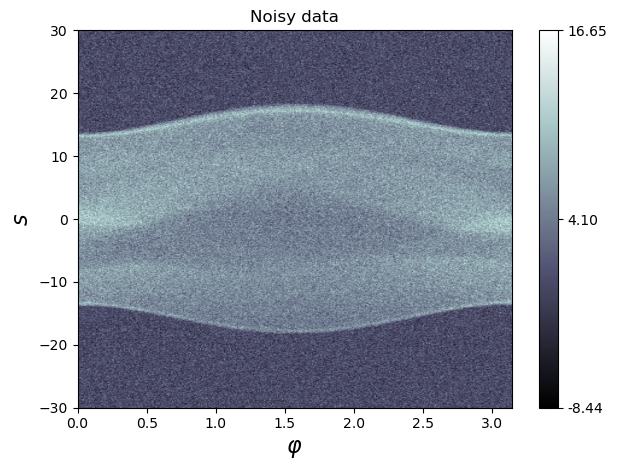

<Figure size 640x480 with 0 Axes>

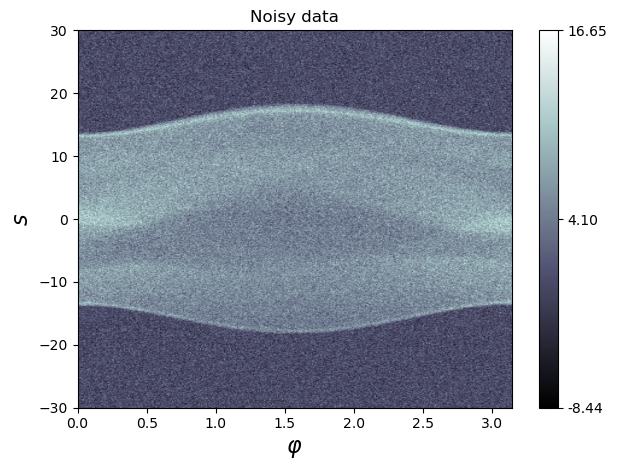

In [3]:
# --- Generate artificial data --- #

# Create phantom
discr_phantom = odl.phantom.shepp_logan(reco_space, modified=True)

# Create sinogram of forward projected phantom with noise
data = ray_trafo(discr_phantom)
data += odl.phantom.white_noise(ray_trafo.range) * np.mean(data) * 0.6
data.show(title='Noisy data');

In [4]:
# --- Set up the inverse problem --- #

# Initialize gradient operator
gradient = odl.Gradient(reco_space)

# Column vector of two operators
op = odl.BroadcastOperator(ray_trafo, gradient)

# Do not use the f functional, set it to zero.
f = odl.solvers.ZeroFunctional(op.domain)

# Create functionals for the dual variable

# l2-squared data matching
l2_norm = odl.solvers.L2NormSquared(ray_trafo.range).translated(data)

# Isotropic TV-regularization i.e. the l1-norm
l1_norm = 0.015 * odl.solvers.L1Norm(gradient.range)

# Combine functionals, order must correspond to the operator K
g = odl.solvers.SeparableSum(l2_norm, l1_norm)

/home/w/wuebbel/.local/lib/python3.10/site-packages/odl/discr/discr_utils.py:628: UserWarning: Unable to infer accurate dtype for interpolation coefficients, defaulting to `float`.
  warn("Unable to infer accurate dtype for"


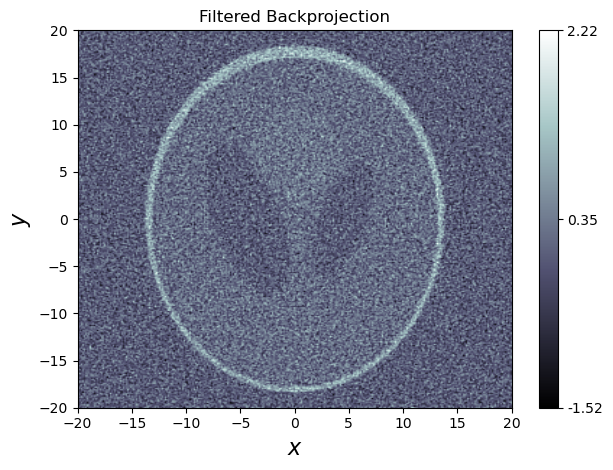

<Figure size 640x480 with 0 Axes>

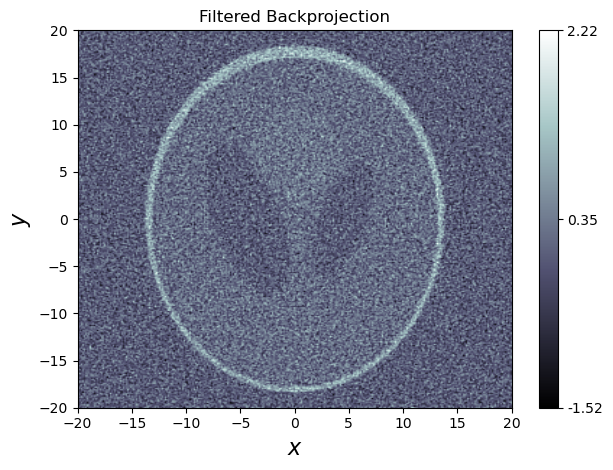

In [5]:
# FBP
# Fourier transform in detector direction
fourier = odl.trafos.FourierTransform(ray_trafo.range, axes=[1])

# Create ramp in the detector direction
ramp_function = fourier.range.element(lambda x: np.abs(x[1]) / (2 * np.pi))

# Create ramp filter via the convolution formula with fourier transforms
ramp_filter = fourier.inverse * ramp_function * fourier

# Create filtered back-projection by composing the back-projection (adjoint)
# with the ramp filter.
fbp = ray_trafo.adjoint * ramp_filter

x_ftw=fbp(data)
x_ftw.show(title='Filtered Backprojection')

In [6]:
# --- Select solver parameters and solve using PDHG --- #

# Estimated operator norm, add 10 percent to ensure ||K||_2^2 * sigma * tau < 1
op_norm = 1.1 * odl.power_method_opnorm(op)

/home/w/wuebbel/.local/lib/python3.10/site-packages/odl/discr/discr_utils.py:628: UserWarning: Unable to infer accurate dtype for interpolation coefficients, defaulting to `float`.
  warn("Unable to infer accurate dtype for"


iter = 0


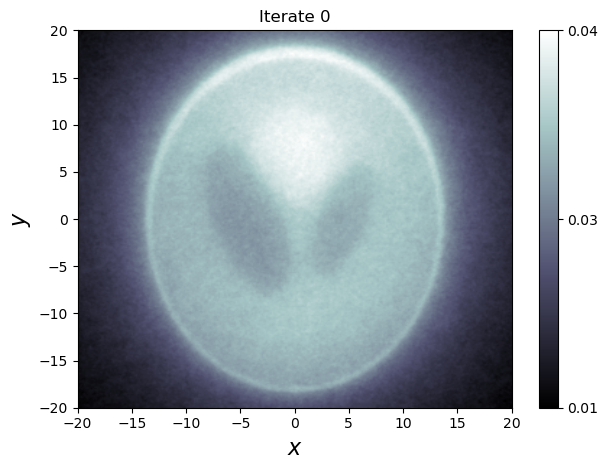

<Figure size 640x480 with 0 Axes>

/home/w/wuebbel/.local/lib/python3.10/site-packages/odl/discr/discr_utils.py:628: UserWarning: Unable to infer accurate dtype for interpolation coefficients, defaulting to `float`.
  warn("Unable to infer accurate dtype for"


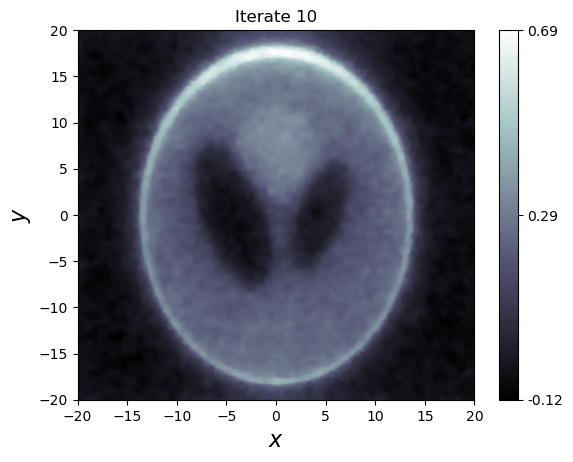

<Figure size 640x480 with 0 Axes>

/home/w/wuebbel/.local/lib/python3.10/site-packages/odl/discr/discr_utils.py:628: UserWarning: Unable to infer accurate dtype for interpolation coefficients, defaulting to `float`.
  warn("Unable to infer accurate dtype for"


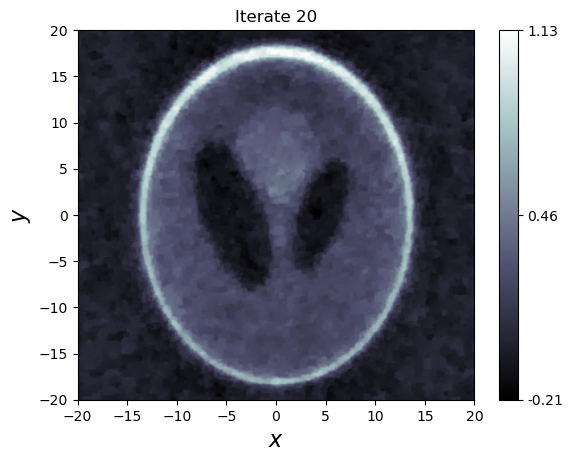

<Figure size 640x480 with 0 Axes>

/home/w/wuebbel/.local/lib/python3.10/site-packages/odl/discr/discr_utils.py:628: UserWarning: Unable to infer accurate dtype for interpolation coefficients, defaulting to `float`.
  warn("Unable to infer accurate dtype for"


iter = 30


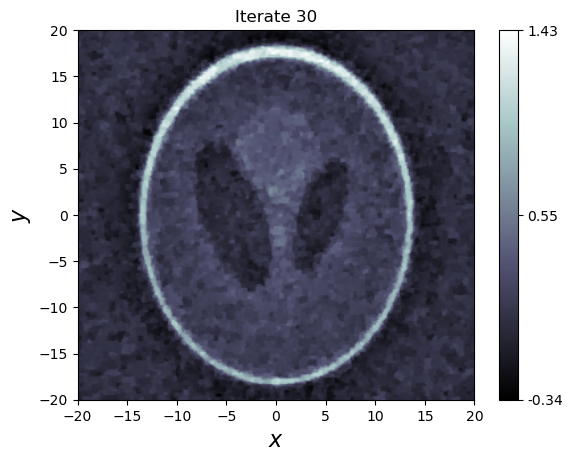

<Figure size 640x480 with 0 Axes>

/home/w/wuebbel/.local/lib/python3.10/site-packages/odl/discr/discr_utils.py:628: UserWarning: Unable to infer accurate dtype for interpolation coefficients, defaulting to `float`.
  warn("Unable to infer accurate dtype for"


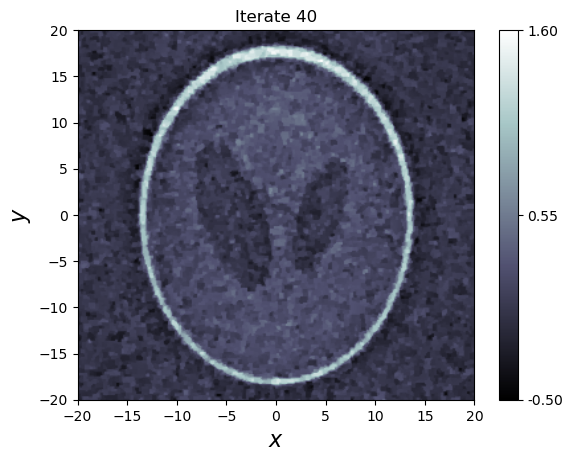

<Figure size 640x480 with 0 Axes>

/home/w/wuebbel/.local/lib/python3.10/site-packages/odl/discr/discr_utils.py:628: UserWarning: Unable to infer accurate dtype for interpolation coefficients, defaulting to `float`.
  warn("Unable to infer accurate dtype for"


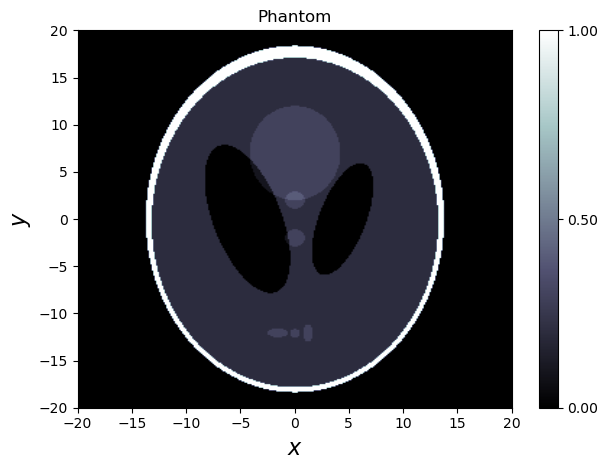

<Figure size 640x480 with 0 Axes>

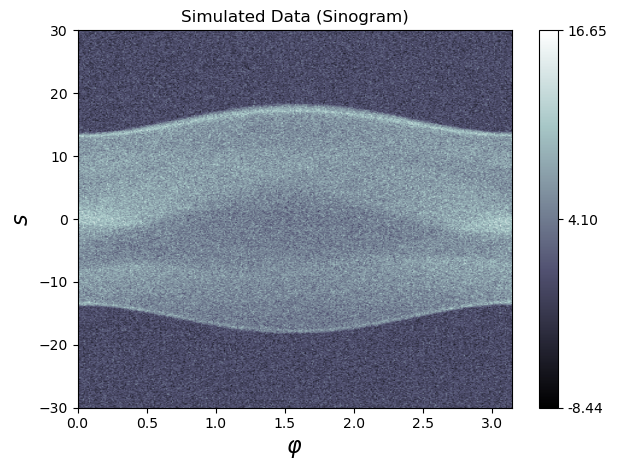

<Figure size 640x480 with 0 Axes>

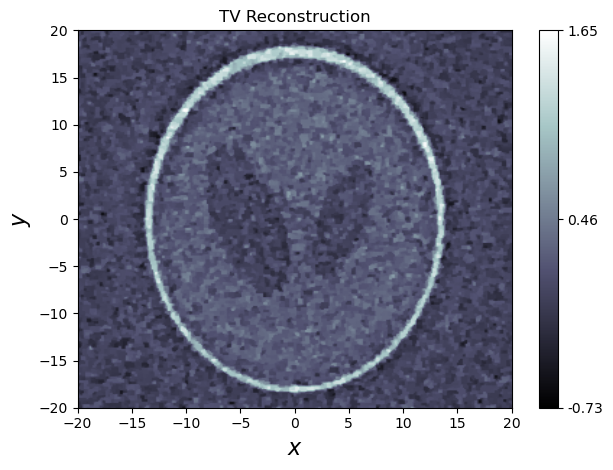

<Figure size 640x480 with 0 Axes>

In [7]:
niter = 50  # Number of iterations
tau = 1.0 / op_norm  # Step size for the primal variable
sigma = 1.0 / op_norm  # Step size for the dual variable

# Optionally pass callback to the solver to display intermediate results
callback = (odl.solvers.CallbackPrintIteration(step=30) &
            odl.solvers.CallbackShow(step=10))

# Choose a starting point
x = op.domain.zero()


# Run the algorithm
odl.solvers.pdhg(x, f, g, op, niter=niter, tau=tau, sigma=sigma,
                 callback=callback)

# Display images
discr_phantom.show(title='Phantom')
data.show(title='Simulated Data (Sinogram)')
x.show(title='TV Reconstruction', force_show=True);